# NETWORK SCIENCE #

# Rapid Rail Network #

## Introduction ##

For the purpose of network analysis under the Network Science course, the dataset of **Rapid Rail Explorer** will be used. This dataset is owned by Prasarana Malaysia. Prasarana is the owner-operator of the country's rail services, including LRT networks, KL monorail and the MRT lines. In addition to that, they are also the owner-operator for the stage bus services in Kuala Lumpur, Selangor, Penang and Pahang. All these comprise what is commonly known as Rapid Rail and Rapid Bus systems. This dataset provides granular ridership data between Rapid Rail stations, including LRT networks, KL monorail and MRT lines. Analyzing passenger flows between stations can reveal patterns in public transportation usage.

This dataset can be acquired through url https://data.gov.my/dashboard/rapid-explorer. Though, the dataset must be retrieve programmatically via the API.

## Data Exploratory ##

The Rapid Rail Explorer data is accessible through the **GTFS Statis API** which provides standardized public transportation schedules and geographic information. The following is the code to retrieve the data using API:

In [2]:
import requests
import pandas as pd
import zipfile
import io
import os

# define the API endpoint
api_url = "https://api.data.gov.my/gtfs-static/prasarana?category=rapid-rail-kl"

# request to the API
response = requests.get(api_url)

# check if the request was successful
if response.status_code == 200:
    # load the content into BytesIO object
    z = zipfile.ZipFile(io.BytesIO(response.content))
    # extract all files into current directory
    z.extractall()
    print("Files extracted successfully.")
    # load specific GTFS files into pandas DataFrames
    stops_df = pd.read_csv('stops.txt')
    trips_df = pd.read_csv('trips.txt')
    stop_times_df = pd.read_csv('stop_times.txt')
    routes_df = pd.read_csv('routes.txt')
    # save each DataFrame to a csv file
    stops_df.to_csv("stops.csv", index = False)
    trips_df.to_csv("trips.csv", index = False)
    stop_times_df.to_csv("stop_times.csv", index = False)
    routes_df.to_csv("routes.csv", index = False)
    print("Data successfully saved to CSV files.")
else:
    print(f"Failed to retrieve data. Status code: {response.status_code}")    

Files extracted successfully.
Data successfully saved to CSV files.


There will be a set of files extracted from the API. Then all those dataset need to be combined as follows:

In [4]:
# load the extracted csv files
stops_df = pd.read_csv('stops.csv')
trips_df = pd.read_csv('trips.csv')
stop_times_df = pd.read_csv('stop_times.csv')
routes_df = pd.read_csv('routes.csv')

# merge stop_times with stops based on stop_id
stops_combined = pd.merge(stop_times_df, stops_df, on = 'stop_id', how = 'left')

# merge the result with trips based on trip_id
trips_combined = pd.merge(stops_combined, trips_df, on = 'trip_id', how = 'left')

# merge the result with routes based on route_id
final_combined_df = pd.merge(trips_combined, routes_df, on = 'route_id', how = 'left')

# save the final combined DataFrame to a csv file
final_combined_df.to_csv('combined_rapid_rail_data.csv', index = False)

print("All csv files successfully combined into 'combined_rapid_rail_data.csv'")

All csv files successfully combined into 'combined_rapid_rail_data.csv'


In [9]:
data = pd.read_csv("combined_rapid_rail_data.csv")
data.head()

,route_id_x,direction_id_x,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_name,stop_lat,stop_lon,...,shape_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_color,route_text_color,category_y,status_y
0,AGL,0,AGL_MonFri_0,6:00:00,6:00:18,AG18,1,AMPANG,3.150318,101.760049,...,shp_AG_0,rapidrail,AGL,LRT Ampang Line,Ampang ~ Chan Sow Lin,1,e57200,FFFFFF,LRT,valid
1,AGL,0,AGL_MonFri_0,6:02:03,6:02:21,AG17,2,CAHAYA,3.140575,101.756677,...,shp_AG_0,rapidrail,AGL,LRT Ampang Line,Ampang ~ Chan Sow Lin,1,e57200,FFFFFF,LRT,valid
2,AGL,0,AGL_MonFri_0,6:03:15,6:03:33,AG16,3,CEMPAKA,3.138324,101.752979,...,shp_AG_0,rapidrail,AGL,LRT Ampang Line,Ampang ~ Chan Sow Lin,1,e57200,FFFFFF,LRT,valid
3,AGL,0,AGL_MonFri_0,6:04:43,6:05:01,AG15,4,PANDAN INDAH,3.134581,101.746509,...,shp_AG_0,rapidrail,AGL,LRT Ampang Line,Ampang ~ Chan Sow Lin,1,e57200,FFFFFF,LRT,valid
4,AGL,0,AGL_MonFri_0,6:06:21,6:06:39,AG14,5,PANDAN JAYA,3.130141,101.739122,...,shp_AG_0,rapidrail,AGL,LRT Ampang Line,Ampang ~ Chan Sow Lin,1,e57200,FFFFFF,LRT,valid


### 1. Selecting a relevant columns for network analysis ###

After combining all the dataset, there are a **total of 30 columns**. The prepare the dataset for network analysis, the data should be cleaned and transformed to contruct a meaningful relationship between stations to identify the vertices and edges for the network system. The columns to be selected are **trip_id, stop_id, stop_name and stop_sequence**.The selected columns will then be saved as new dataset called **network_analysis_data.csv**. The code to construct the relevant columns are as follows:

In [12]:
# load the dataset
file_path = 'combined_rapid_rail_data.csv'
data = pd.read_csv(file_path)

# select relevant columns
columns_to_keep = ['trip_id', 'stop_id', 'stop_name', 'stop_sequence']
network_data = data[columns_to_keep]

# sort data by trip_id and stop_sequence to ensure order for edge construction
network_data = network_data.sort_values(by = ['trip_id', 'stop_sequence'])

# construct edges by pairing consecutive stations within the same trip
edges = network_data.groupby('trip_id').apply(
    lambda x: pd.DataFrame({
        'from_stop_id': x['stop_id'].iloc[:-1].values,
        'to_stop_id': x['stop_id'].iloc[1:].values,
        'from_stop_name': x['stop_name'].iloc[:-1].values,
        'to_stop_name': x['stop_name'].iloc[1:].values
    })
).reset_index(drop = True)

# save the cleaned dataset
output_file_path = 'C:/Users/kamar/Network_Science/network_analysis_data.csv'
edges.to_csv(output_file_path, index = False)

In [13]:
data = pd.read_csv("network_analysis_data.csv")
data.head()

,from_stop_id,to_stop_id,from_stop_name,to_stop_name
0,AG18,AG17,AMPANG,CAHAYA
1,AG17,AG16,CAHAYA,CEMPAKA
2,AG16,AG15,CEMPAKA,PANDAN INDAH
3,AG15,AG14,PANDAN INDAH,PANDAN JAYA
4,AG14,AG13,PANDAN JAYA,MALURI


### 2. Determining the Vertices and Edges of the network ###

The vertices for this network is the name of the station and the edges is the stop sequence for each station. The visualization of the network are as below:

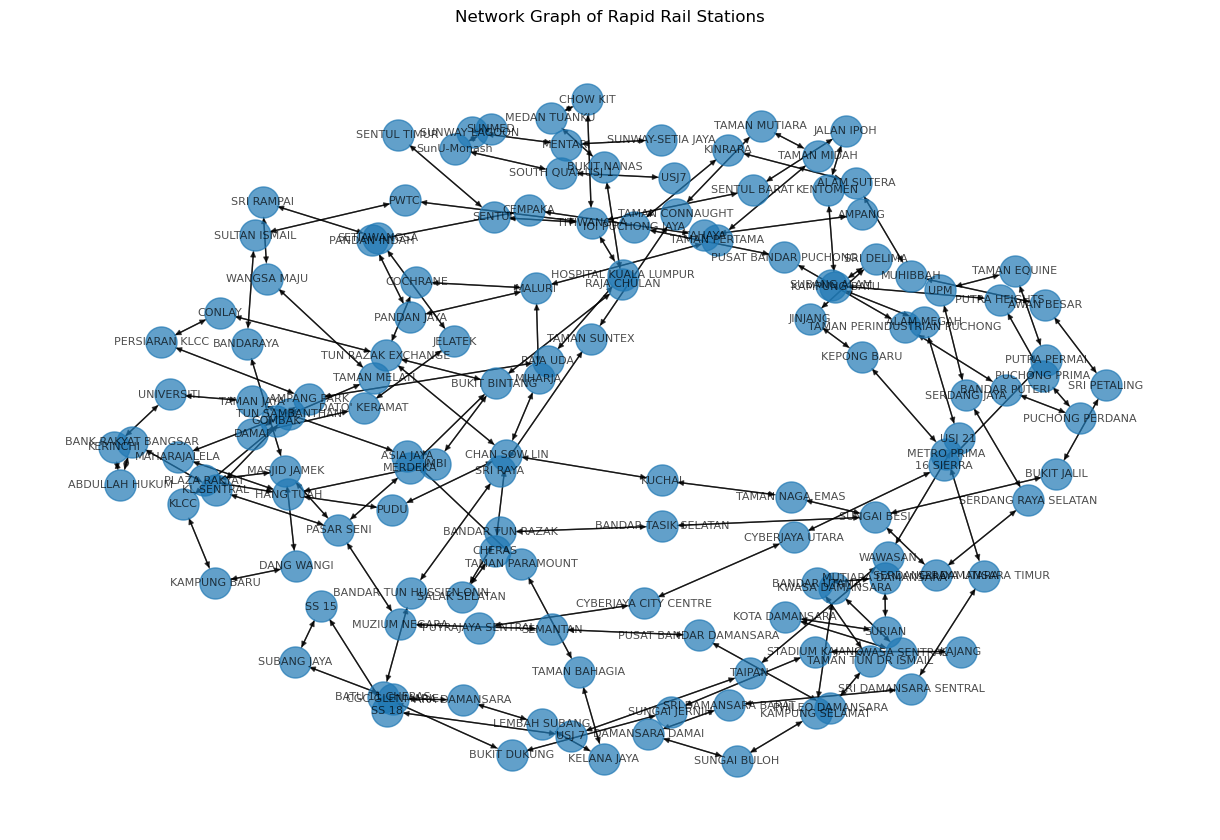

(142, 300)

In [20]:
import networkx as nx
import matplotlib.pyplot as plt

# create edges 
edges = list(zip(data['from_stop_name'], data['to_stop_name']))

# initialize the graph
G = nx.DiGraph()
G.add_edges_from(edges)

# number of vertices and edges
num_vertices = G.number_of_nodes()
num_edges = G.number_of_edges()

# visualize the graph
plt.figure(figsize = (12, 8))
pos = nx.spring_layout(G, k = 0.3)
nx.draw(G, pos, with_labels = True, node_size = 500, font_size = 8, alpha = 0.7, arrowsize = 8)
plt.title("Network Graph of Rapid Rail Stations")
plt.show()

num_vertices, num_edges

### Number of Vertices = 142 ###

### Number of Edges = 300 ###

### 3. Determining the Minimum Spanning Tree (MST) ###

To find the minimum spanning tree (MST), an undirected version of the network must be created as for MST analysis we need an undirected graph.

### Creating Undirected Rail Network ###

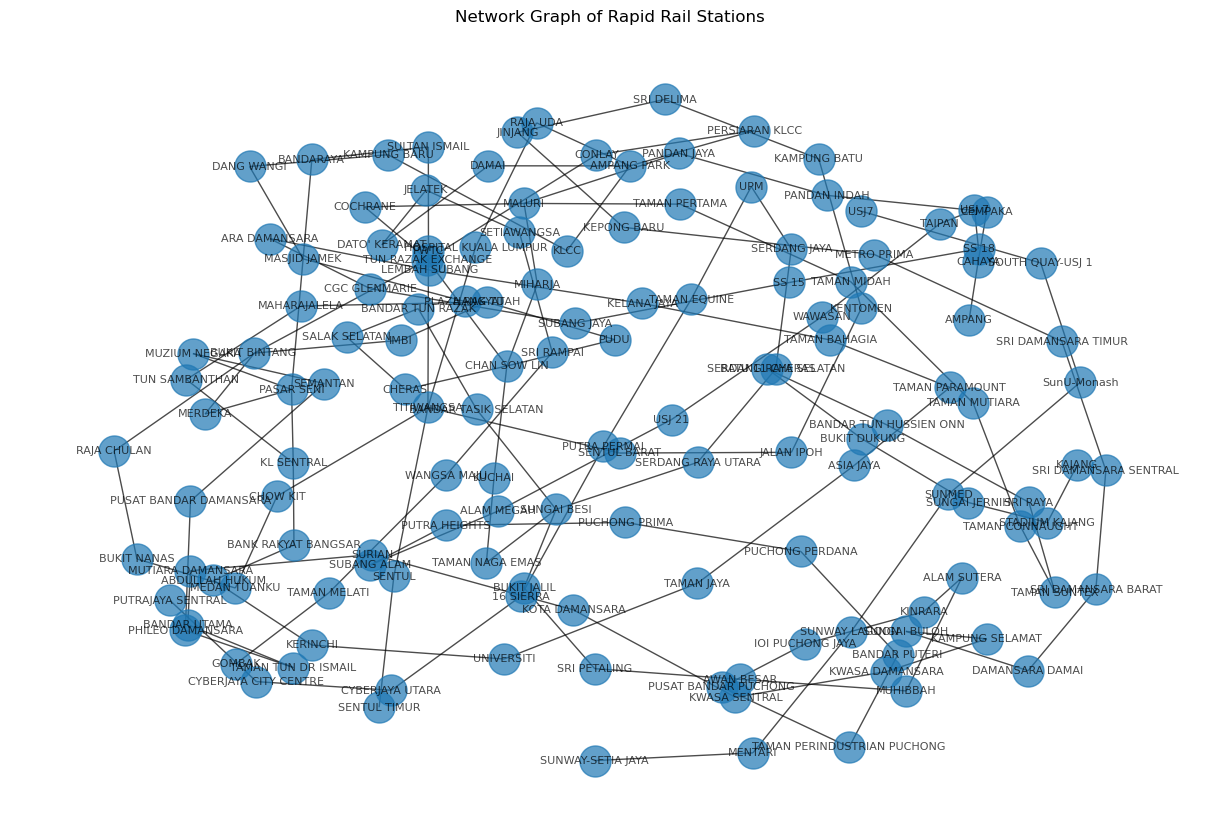

(142, 150)

In [25]:
import networkx as nx
import matplotlib.pyplot as plt

# create edges 
edges = list(zip(data['from_stop_name'], data['to_stop_name']))

# initialize the graph
G = nx.Graph()
G.add_edges_from(edges)

# number of vertices and edges
num_vertices = G.number_of_nodes()
num_edges = G.number_of_edges()

# visualize the graph
plt.figure(figsize = (12, 8))
pos = nx.spring_layout(G, k = 0.3)
nx.draw(G, pos, with_labels = True, node_size = 500, font_size = 8, alpha = 0.7)
plt.title("Network Graph of Rapid Rail Stations")
plt.show()

num_vertices, num_edges

### Visualizing the MST ###

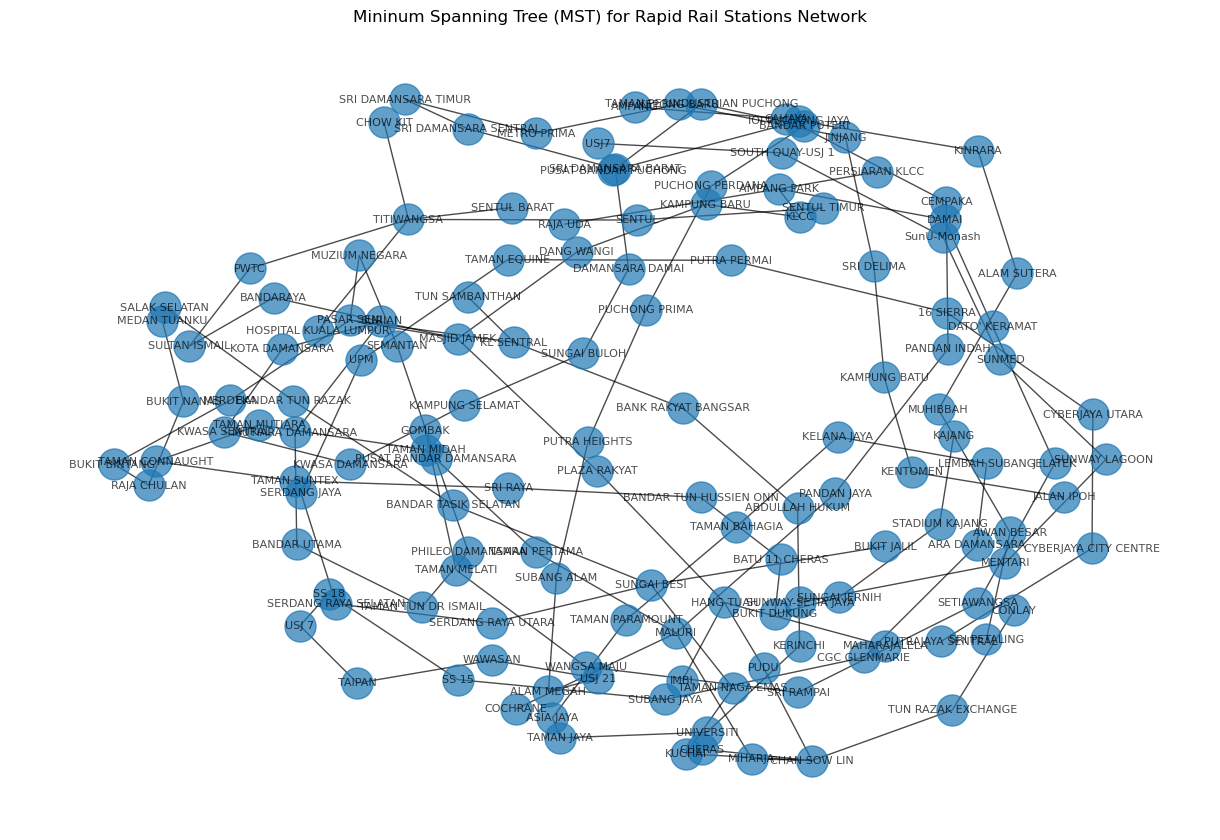

(142, 140)

In [24]:
mst = nx.minimum_spanning_tree(G)

# number of vertices and edges in the MST
mst_num_vertices = mst.number_of_nodes()
mst_num_edges = mst.number_of_edges()

# visualize the MST
plt.figure(figsize = (12, 8))
pos_mst = nx.spring_layout(mst, k = 0.3)
nx.draw(mst, pos_mst, with_labels = True, node_size = 500, font_size = 8, alpha = 0.7)
plt.title("Mininum Spanning Tree (MST) for Rapid Rail Stations Network")
plt.show()

mst_num_vertices, mst_num_edges

### For this MST: ###

Number of vertices: **142**

Number of edges: **140**

### The importance of MST to the rail network ###

The MST provides a simplified version of the network that preserves essential connectivity with the minimum number of connection. Some of the importance of MST in this network are:

+ minimizes the number of edges needed to keep all the stations connected, representing the most efficient way to connect every station without redundant paths.
+ it maintains connectivity across all stations, ensuring there are no isolated parts which is essential for robust and accessible transit.
+ reduces the network to its most necessary components by making it easier to identify and address potential vulnerabilities such as heavily relied-upon stations or connections.

### 4. Determine the shortest path of the rail network ###

To visualize shortest paths across the entire network, we can compute shortest path trees from a sample station and display a few paths due to the size as follows:

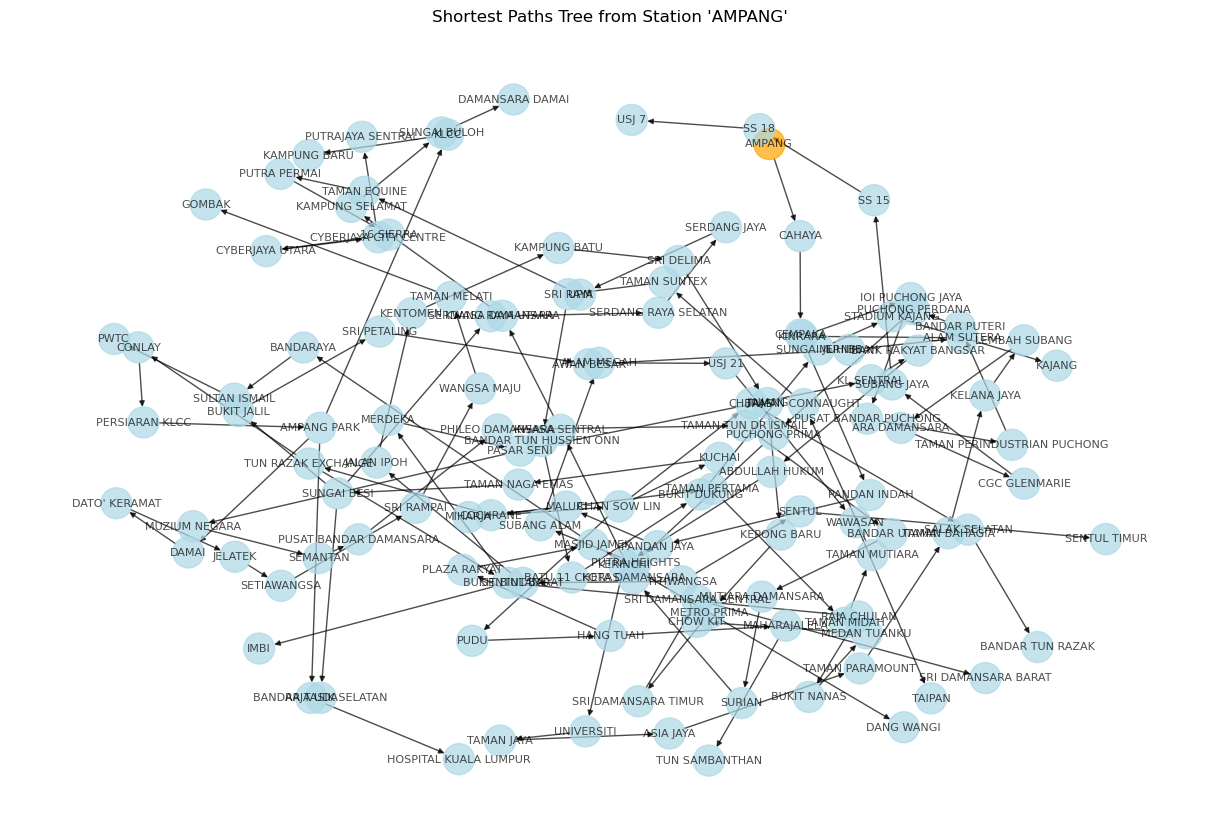

In [33]:
# Create directed edges from `from_stop_name` to `to_stop_name` 
edges_directed = list(zip(data['from_stop_name'], data['to_stop_name']))

# Initialize the directed graph
G_directed = nx.DiGraph()
G_directed.add_edges_from(edges_directed)

# Re-select the starting station
starting_station = data['from_stop_name'].iloc[0]

# Compute shortest paths from the starting station to all others in the directed graph
shortest_paths_tree = nx.single_source_shortest_path(G_directed, starting_station)

# Create a new graph to represent only the shortest paths from the starting station
shortest_paths_graph = nx.DiGraph()
for target_station, path in shortest_paths_tree.items():
    # Add edges for each shortest path found from starting station to target station
    path_edges = list(zip(path[:-1], path[1:]))
    shortest_paths_graph.add_edges_from(path_edges)

# Set up node color mapping: highlight the starting station with a unique color
node_colors = ['lightblue' if node != starting_station else 'orange' for node in shortest_paths_graph.nodes()]
    
# Visualize the shortest paths tree from the starting station
plt.figure(figsize=(12, 8))
pos_paths = nx.spring_layout(shortest_paths_graph, k=0.3)
nx.draw(shortest_paths_graph, pos_paths, with_labels=True, node_size=500, font_size=8, alpha=0.7, arrowsize=8,
       node_color = node_colors)
plt.title(f"Shortest Paths Tree from Station '{starting_station}'")
plt.show()

### 5. Determine the Clustering Coefficient of the rail network ###

The clustering coefficient measures the degree to which vertices in the graph tend to cluster together.

In [35]:
clustering_coeff = nx.average_clustering(G)
clustering_coeff

0.0

The clustering coeffiecient of the network is **0.00**. This value suggest that there is little to no clustering within the network meaning that stations do not form tightly interconnected groups or triangles.

This result indicates that the rail network is more of a linear or tree-like structure with stations primarily connected in a sequential or branching manner rather than forming small, interconnected subgroups.

### 6. Determine the Degree of Centrality of the rail network ##

Degree centrality gives an indication of the number of direct connections each vertex has.

In [36]:
degree_centrality = nx.degree_centrality(G_directed)

# display top 5 stations with highest degree of centralities
top_degree_centrality = dict(sorted(degree_centrality.items(), key = lambda item: item[1], reverse = True)[:5])

top_degree_centrality

{'CHAN SOW LIN': 0.07092198581560283,
 'TITIWANGSA': 0.07092198581560283,
 'MALURI': 0.05673758865248227,
 'HANG TUAH': 0.05673758865248227,
 'MASJID JAMEK': 0.05673758865248227}

The top 5 stations with highest degree of centrality are:

+ Chan Sow Lin: 0.071
+ Titiwangsa: 0.071
+ Maluri: 0.057
+ Hang Tuah: 0.057
+ Masjid Jamek: 0.057

This indicates that these 5 stations are important hubs within the rail network. High degree centrality often signifies a station's importance in facilitating passenger flow and providing connectivity to multiple other stations.

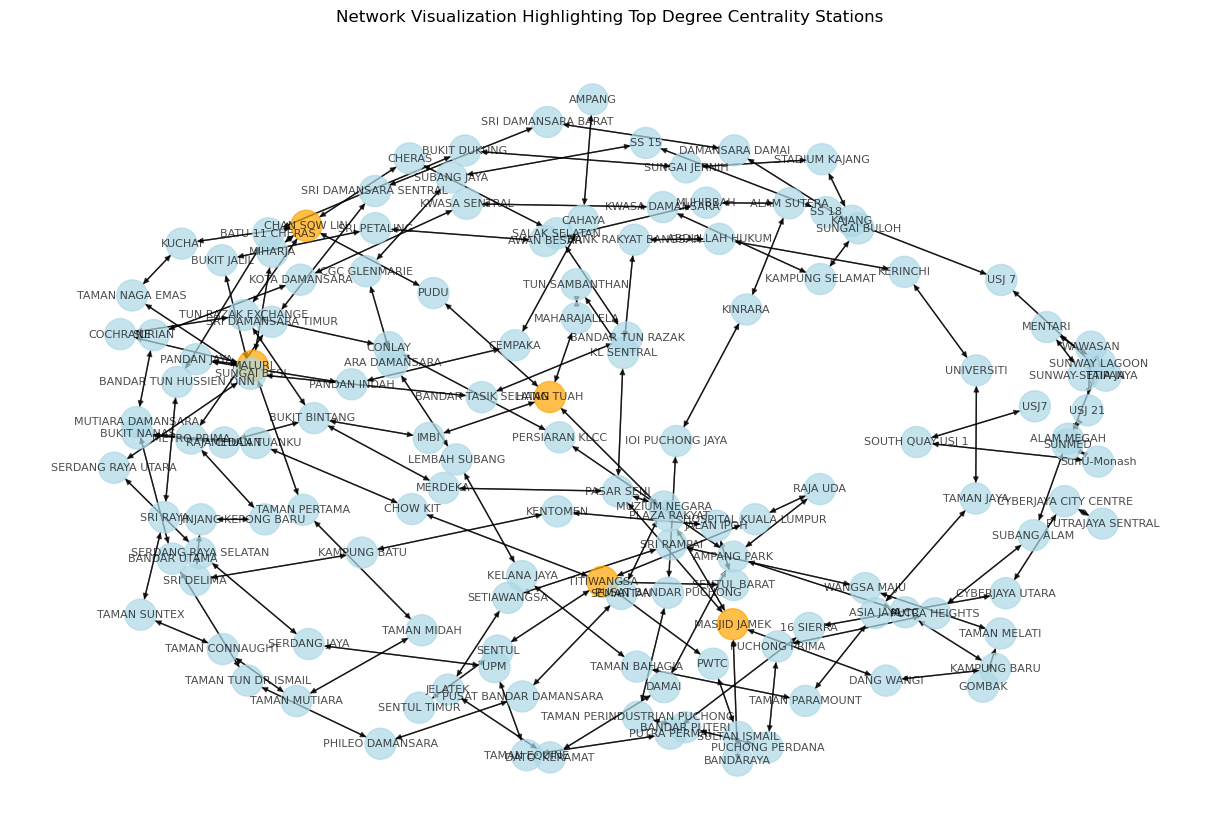

In [41]:
top_nodes = list(top_degree_centrality.keys())

# Color mapping: orange for top nodes, light blue for others
node_colors = ['orange' if node in top_nodes else 'lightblue' for node in G_directed.nodes()]

# Visualize the graph, emphasizing top degree centrality nodes
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_directed, k=0.3)
nx.draw(G_directed, pos, with_labels=True, node_size=500, font_size=8, alpha=0.7, arrowsize=8, node_color=node_colors)
plt.title("Network Visualization Highlighting Top Degree Centrality Stations")
plt.show()

### 7. Determine the Closeness Centrality of the rail network ###

Closeness centrality measures how quickly a vertex can reach all other vertices in the network.

In [37]:
closeness_centrality = nx.closeness_centrality(G_directed)

# dislplay top 5 stations with highest closeness centrality
top_closeness_centrality = dict(sorted(closeness_centrality.items(), key = lambda item: item[1], reverse = True)[:5])

top_closeness_centrality

{'TUN RAZAK EXCHANGE': 0.11092989349346381,
 'BUKIT BINTANG ': 0.11025759110865495,
 'CHAN SOW LIN': 0.10819670155522214,
 'MERDEKA': 0.1059463541851052,
 'PASAR SENI': 0.10577036356353525}

The top 5 stations with the highest closeness centrality are:

+ Tun Razak Exchange: 0.111
+ Bukit Bintang: 0.110
+ Chan Sow Lin: 0.108
+ Merdeka: 0.106
+ Pasar Seni: 0.106

This indicates that stations with high closeness centrality can reach other stations more quickly on average. This indicates that these stations are centrally located within the network, making them efficient access points for passengers traveling across different parts of the rail system.

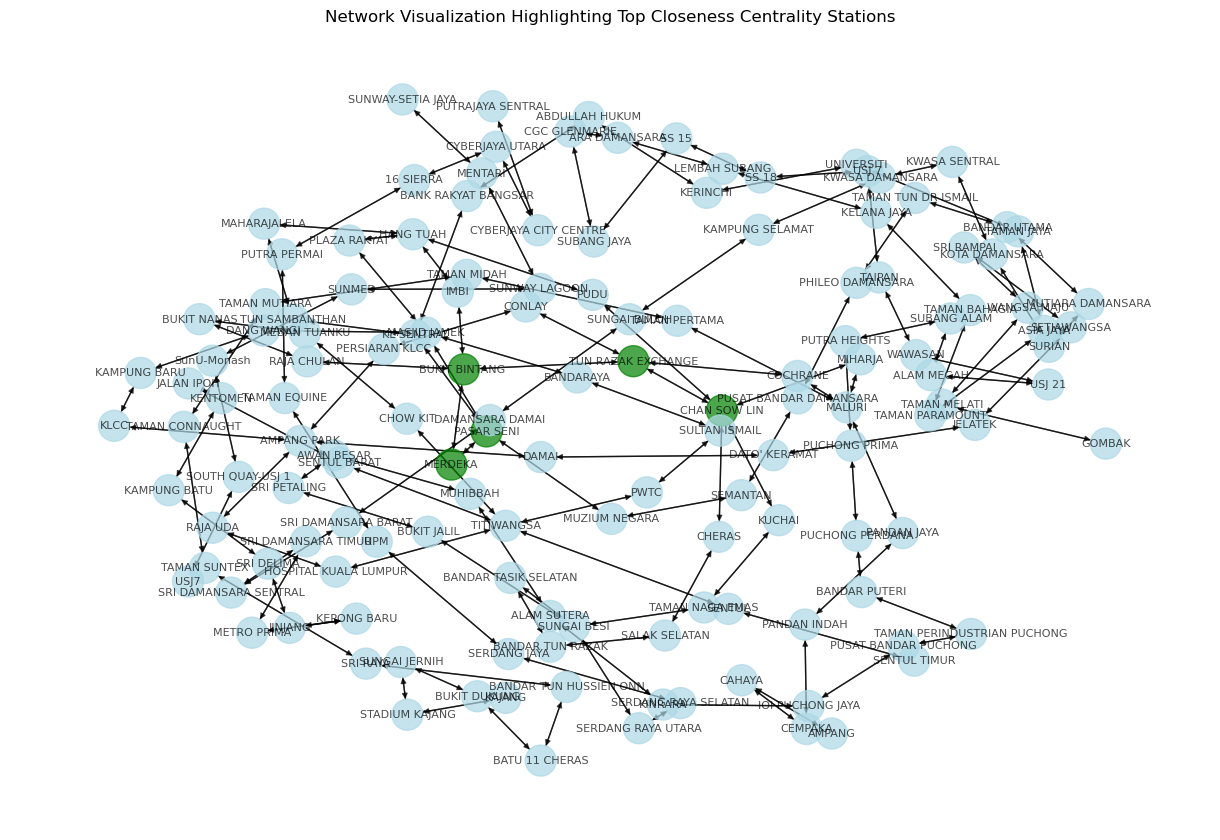

In [40]:
top_closeness_nodes = list(top_closeness_centrality.keys())

# Color mapping: green for top closeness nodes, light blue for others
node_colors = ['green' if node in top_closeness_nodes else 'lightblue' for node in G_directed.nodes()]

# Visualize the graph, emphasizing top closeness centrality nodes
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_directed, k=0.3)
nx.draw(G_directed, pos, with_labels=True, node_size=500, font_size=8, alpha=0.7, arrowsize=8, node_color=node_colors)
plt.title("Network Visualization Highlighting Top Closeness Centrality Stations")
plt.show()